## Software Life Cycle 

In [1]:
import os
from dotenv import load_dotenv

# Load env vars
load_dotenv()

True

In [2]:
from langchain_groq import ChatGroq

# Initialize Llama model
llm = ChatGroq(model="llama3-70b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x750f44f88460>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x750f44f89810>, model_name='llama3-70b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [4]:
from typing import List
from pydantic import BaseModel, Field


class UserStory(BaseModel):
    title: str = Field(
        description="Title of the user story summarizing the functionality."
    )
    description: str = Field(
        description="Detailed user story following the format: 'As a [user], I want to [action] so that [benefit]'."
    )
    acceptance_criteria: List[str] = Field(
        description="List of acceptance criteria that define when this story is complete."
    )


class UserStories(BaseModel):
    stories: List[UserStory] = Field(
        default_factory=list, description="List of generated user stories."
    )
    
user_story_evaluator = llm.with_structured_output(UserStories)

In [24]:
from typing_extensions import TypedDict
from src.state.user_stories import UserStories


class LifeCycleState(TypedDict):
    prompt: str
    user_stories: UserStories
    review_design_status: str
    product_owner_review_status: str

In [26]:
# Nodes
def get_user_requirement(state: LifeCycleState):
    """Generates structured user stories from user requirements using the `UserStories` schema."""
    result = user_story_evaluator.invoke(
        f"Split the following requirements into distinct user stories. "
        f"Each user story should include a title, description, and acceptance criteria: {state['prompt']}"
    )
    return {"user_stories": result}

def create_user_stories(state: LifeCycleState):
    if not state["user_stories"].stories:
        print("No user stories found.")
        return

    for story in state["user_stories"].stories:
        print(f"Title: {story.title}")
        print(f"Description: {story.description}")
        print(f"Acceptance Criteria: {story.acceptance_criteria}")
        print("="*100, "\n")
        
    pass


def review_by_product_owner(state: LifeCycleState):
    pass


def create_design_documents(state: LifeCycleState):
    pass


def revise_user_stories(state: LifeCycleState):
    pass


def review_design_documents(state: LifeCycleState):
    pass

def generate_code(state: LifeCycleState):
    pass


def route_product_owner_review(state: LifeCycleState):
    if state.product_owner_review_status == "accepted":
        return "Accepted"
    elif state.product_owner_review_status == "feedback":
        return "Feedback"
    
def route_review_design_document(state: LifeCycleState):
    if state.review_design_status == "accepted":
        return "Accepted"
    elif state.review_design_status == "feedback":
        return "Feedback"

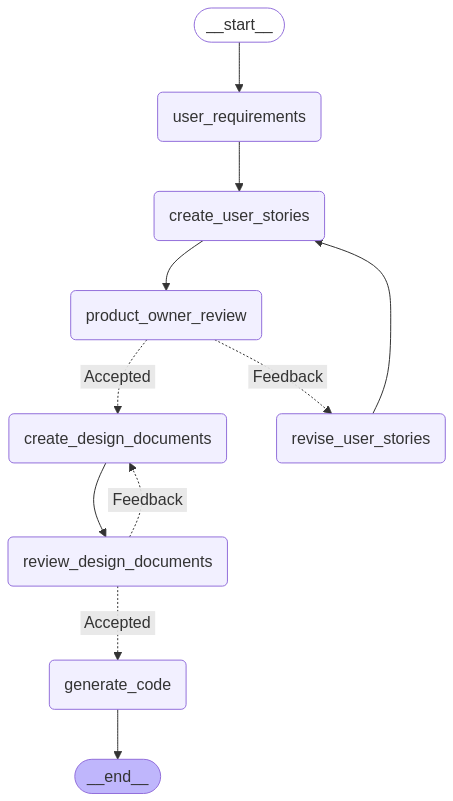

In [27]:
from langgraph.graph import StateGraph, START, END

# Build Workflow
workflow_builder = StateGraph(LifeCycleState)

# Add nodes
workflow_builder.add_node("user_requirements", get_user_requirement)
workflow_builder.add_node("create_user_stories", create_user_stories)
workflow_builder.add_node("product_owner_review", review_by_product_owner)
workflow_builder.add_node("create_design_documents", create_design_documents)
workflow_builder.add_node("revise_user_stories", revise_user_stories)
workflow_builder.add_node("review_design_documents", review_design_documents)
workflow_builder.add_node("generate_code", generate_code)


# Add edges to connect nodes
workflow_builder.add_edge(START, "user_requirements")
workflow_builder.add_edge("user_requirements", "create_user_stories")
workflow_builder.add_edge("create_user_stories", "product_owner_review")
workflow_builder.add_conditional_edges(
    "product_owner_review",
    route_review_design_document,
    {
        "Accepted": "create_design_documents",
        "Feedback": "revise_user_stories",
    },
)
workflow_builder.add_edge("revise_user_stories", "create_user_stories")
workflow_builder.add_edge("create_design_documents", "review_design_documents")
workflow_builder.add_conditional_edges(
    "review_design_documents",
    route_product_owner_review,
    {
        "Accepted": "generate_code",
        "Feedback": "create_design_documents",
    },
)
workflow_builder.add_edge("generate_code", END)

# Compile
workflow = workflow_builder.compile()
workflow

In [23]:
prompt = "I want to develop a user management system with two user types: Admin and User. Admins will have the ability to create, list, update, and delete users, while Users will only be able to retrieve their own details using their user ID."
result = workflow.invoke({ "prompt": prompt })

Title: As an Admin, I want to create a new user
Description: As an Admin, I want to create a new user with a unique ID, username, and password, so that I can manage users efficiently.
Acceptance Criteria: ['The system allows Admins to create a new user with a unique ID, username, and password.', 'The system validates the input data for the new user.', "The system stores the new user's details in the database.", 'The system returns a success message upon successful creation of a new user.']

Title: As an Admin, I want to list all users
Description: As an Admin, I want to retrieve a list of all users, so that I can view and manage users efficiently.
Acceptance Criteria: ['The system allows Admins to retrieve a list of all users.', 'The system returns a list of all users with their IDs, usernames, and other relevant details.', 'The system paginates the list of users if the number of users exceeds a certain threshold.']

Title: As an Admin, I want to update a user's details
Description: As

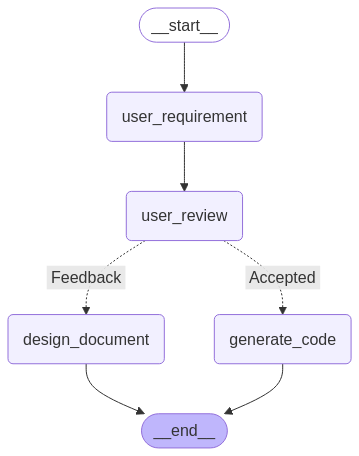

In [3]:
import streamlit as st
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

# Load env vars
load_dotenv()

# Initialize Llama model
llm = ChatGroq(model="llama3-70b-8192")


class State(TypedDict):
    prompt: str
    content: str
    documents: str
    codes: str
    user_review_status: str
    feedback: str  # Added feedback field


# Nodes
def get_user_requirement(state: State):
    """Act as a senior data scientist. Please give an answer based on your ability."""
    result = llm.invoke(f"Give me the answer for the query: {state['prompt']}")
    return {"content": result.content}


def review_by_user(state: State):
    user_input = input("Enter review status (Accepted/Feedback): ").strip().lower()
    if user_input == "accepted":
        return {"user_review_status": "accepted"}
    elif user_input == "feedback":
        feedback = input("Provide feedback details: ").strip()
        return {"user_review_status": "feedback", "feedback": feedback}
    else:
        print("Invalid input. Defaulting to 'feedback'.")
        return {"user_review_status": "feedback", "feedback": "Default feedback."}



def create_design_document(state: State):
    return {"documents": "Document created."}


def generate_code(state: State):
    return {"codes": "Code generated."}


def route_user_review(state: State):
    if state["user_review_status"] == "accepted":
        return "Accepted"
    elif state["user_review_status"] == "feedback":
        return "Feedback"


# Build Workflow
workflow_builder = StateGraph(State)

# Add nodes
workflow_builder.add_node("user_requirement", get_user_requirement)
workflow_builder.add_node("user_review", review_by_user)
workflow_builder.add_node("design_document", create_design_document)
workflow_builder.add_node("generate_code", generate_code)


# Add edges to connect nodes
workflow_builder.add_edge(START, "user_requirement")
workflow_builder.add_edge("user_requirement", "user_review")
workflow_builder.add_conditional_edges(
    "user_review",
    route_user_review,
    {
        "Accepted": "generate_code",
        "Feedback": "design_document",
    },
)
workflow_builder.add_edge("generate_code", END)
workflow_builder.add_edge("design_document", END)

workflow = workflow_builder.compile() 
workflow

In [4]:
workflow.invoke({"prompt": "Generative AI"})

{'prompt': 'Generative AI',
 'content': "**What is Generative AI?**\n\nGenerative AI, also known as Generative Artificial Intelligence, refers to a type of artificial intelligence that can generate new, original content, such as images, videos, music, text, or even entire conversations. This is in contrast to traditional AI systems that can only process and analyze existing data.\n\nGenerative AI models are trained on large datasets and use complex algorithms to learn patterns and relationships within the data. Once trained, they can generate new content that is similar in style and structure to the training data, but not identical to it.\n\n**Types of Generative AI:**\n\n1. **Generative Adversarial Networks (GANs)**: GANs consist of two neural networks that work together to generate new content. One network generates samples, while the other network evaluates the generated samples and tells the first network whether they are realistic or not.\n2. **Variational Autoencoders (VAEs)**: V